<center><h1>Addressing food access challenges - Medicare Advantage</h1></center>

<center>Jason Wang</center>


In [3]:
# 1. Where should we deploy a food access program?
# 2. How many people will be included? How many might be successfully engaged?
# 3. Which subgroup of the population might benefit the most from the program?
# 4. What is the projected impact of this program?

#### EDA and Data Cleaning

In [4]:
# import libraries
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import us


In [5]:
# connect to sqlite database and get table names
connection = sqlite3.connect("challenge.db")
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql_query(query, connection)
#print(tables)

# import tables to pd dataframes and close connections
cdc500 = pd.read_sql_query(f"SELECT * FROM five_hundred_cities;", connection, index_col='index')
usda = pd.read_sql_query(f"SELECT * FROM access;", connection, index_col='index')
var_list= pd.read_sql_query(f"SELECT * FROM variable_list;", connection, index_col='index')
connection.close()

In [6]:
# explore dataframes shapes and visually check the data
display(cdc500.head(3))
#print(cdc500.isnull().sum())
#print(cdc500.shape, "\n")

# check -9999 value as null for USDA sets (USDA site says they store it this way on csv but double check)
display(usda.head(3))
#print(usda.isnull().sum())
#print((usda == '-9999').sum())
#print(usda.shape, "\n")

# inspect variable list (dictionary)
display(var_list.head(3))
var_list.columns = var_list.columns.str.replace(' ', '_')
#print(var_list.shape, "\n")

# The lowest level of geography for RELEVANT DATA is county level from usda data

,StateAbbr,PlaceName,PlaceFIPS,TractFIPS,Place_TractID,Population2010,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,PAPTEST_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
index,,,,,,,,,,,,,,,,,,,,,
0,AL,Birmingham,107000,1073000100,0107000-01073000100,3042,24.4,"(21.2, 27.8)",31.2,"(30.1, 32.2)",...,"(83.4, 86.6)",20.5,"(18.9, 22.2)",45.5,"(44.3, 46.5)",5.5,"( 5.0, 5.9)",28.9,"(23.7, 35.1)","(33.57943283260, -86.7228323926)"
1,AL,Birmingham,107000,1073000300,0107000-01073000300,2735,30.4,"(27.1, 33.7)",30.5,"(29.3, 31.7)",...,"(81.9, 85.6)",22.2,"(20.4, 24.0)",44.5,"(43.2, 45.7)",6.1,"( 5.5, 6.8)",32.9,"(25.5, 40.2)","(33.54282086860, -86.7524339780)"
2,AL,Birmingham,107000,1073000400,0107000-01073000400,3338,24.7,"(21.1, 28.5)",31.5,"(30.2, 32.9)",...,"(82.3, 86.8)",19.4,"(17.5, 21.4)",45.7,"(44.2, 47.0)",5.6,"( 5.0, 6.2)",28.6,"(22.0, 35.1)","(33.56324496330, -86.7640474064)"


,FIPS,State,County,LACCESS_POP10,LACCESS_POP15,PCH_LACCESS_POP_10_15,PCT_LACCESS_POP10,PCT_LACCESS_POP15,LACCESS_LOWI10,LACCESS_LOWI15,...,LACCESS_HISP15,PCT_LACCESS_HISP15,LACCESS_NHASIAN15,PCT_LACCESS_NHASIAN15,LACCESS_NHNA15,PCT_LACCESS_NHNA15,LACCESS_NHPI15,PCT_LACCESS_NHPI15,LACCESS_MULTIR15,PCT_LACCESS_MULTIR15
index,,,,,,,,,,,,,,,,,,,,,
0,1001,AL,Autauga,18428.439685,17496.693038,-5.056026,33.769657,32.062255,5344.427472,6543.676824,...,471.136164,0.863345,86.767975,0.159000,61.169869,0.112092,8.817961,0.016159,482.848633,0.884808
1,1003,AL,Baldwin,35210.814078,30561.264430,-13.204891,19.318473,16.767489,9952.144027,9886.831137,...,1377.874834,0.755973,212.946378,0.116833,181.649648,0.099662,14.819634,0.008131,1127.696098,0.618712
2,1005,AL,Barbour,5722.305602,6069.523628,6.067799,20.840972,22.105560,3135.676086,2948.790251,...,509.377525,1.855183,17.096410,0.062266,39.960527,0.145539,8.082376,0.029436,462.382655,1.684025


,Category Name,Category Code,Subcategory Name,Variable Name,Variable Code,Geography,Units
index,,,,,,,
0,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store, 2010",LACCESS_POP10,CNTY10,Count
1,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store, 2015",LACCESS_POP15,CNTY10,Count
2,Access and Proximity to Grocery Store,ACCESS,Overall,"Population, low access to store (% change), 20...",PCH_LACCESS_POP_10_15,CNTY10,% change


In [7]:
# What questions can I answer with the data?
# Answerable questions with usda data:
# 1. Where should we deploy a food access program?
# 2. How many people will be included? How many might be successfully engaged?
# 3. Which subgroup of the population might benefit the most from the program?
# 4. What is the projected impact of this program?

# cdc500 is interesting but is it even necessary (or helpful) for these questions?
# finish main objectives and evaluate cdc500 as a potential improvement on usda

In [8]:
# preprocess all data

# FIPS Code for track is 2(state) + 3(county) + 6(tract), verify
# FIPS codes for usda df should be 5 digits, verify
# print(cdc500['TractFIPS'].astype(str).str.len().value_counts())
# print(usda['FIPS'].astype(str).str.len().value_counts())

# FIPS Codes are not all 11 digits for cdc500 TractFIPS, not all 5 digits for usda FIPS, error when importing dtype inference?

# solution: add 0 to non 11 digit cdc500 TractFIPS codes, 0 to non 5 digit usda FIPS codes.
cdc500['TractFIPS'] = cdc500['TractFIPS'].astype(str).str.zfill(11)
usda['FIPS'] = usda['FIPS'].astype(str).str.zfill(5)

# check both display correct lengths
print(cdc500['TractFIPS'].str.len().value_counts())
print(usda['FIPS'].str.len().value_counts())

# state and county FIPS codes are first 5 digits of tract FIPS code
cdc500['countyFIPS'] = cdc500['TractFIPS'].astype(str).str[:5]

# sanity check
print(cdc500['countyFIPS'].str.len().value_counts())

TractFIPS
11    27210
Name: count, dtype: int64
FIPS
5    3143
Name: count, dtype: int64
countyFIPS
5    27210
Name: count, dtype: int64


#### 1. Where should we deploy a food access program?
    # Objectives :
    # 1. Identify counties and neighboring counties with aggregated low food accesspopulations, sorted.
    # 2. Visualize the data on a map, colored by gradient for population experiencing low food access
    # 3. Identify the best target for the program

#### Answer: San Bernardino County, CA. + surrounding counties visually and numerically the best target for a food access program. There are also extenuating factors that make this a ideal target.



In [9]:
# see how data looks visually on map by population of low food access to understand where to start (EDA)

# load in geo files for shapes of counties and states
counties = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_county_500k.zip")
states = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_500k.zip")

# explore FIPS codes
# display(counties.head(3))
# display(states.head(3))
# create state + county FIPS column on counties
counties['FIPS'] = counties['STATEFP'] + counties['COUNTYFP']


# Should focus on contiguous us states

# print(dir(us))
# print(dir(us.STATES_CONTIGUOUS))
filt_states = [state.name for state in us.STATES_CONTIGUOUS]
# test = 'Minnesota'
# test in filt_states
# print(counties['STATE_NAME'].isin(filt_states))

In [10]:
# focus on MOST recent data available (2015)
usda = usda.loc[:, ~usda.columns.str.endswith('10')]

# convert percentages to population estimates, may use later
usda['pop_est'] = (usda['LACCESS_POP15'] / (usda['PCT_LACCESS_POP15']/100 ))

# merge to create geo df
usda_geo = usda.merge(counties, on = 'FIPS', how = 'left')
usda_geo = usda_geo.loc[usda_geo['STATE_NAME'].isin(filt_states),:]

#print(usda.shape)
#print(usda_geo.shape)

# convert to geo df for plotting
usda_geo = gpd.GeoDataFrame(usda_geo, geometry='geometry')

# check for missing counties in original usda data (contiguous)
# missing_counties = counties[~counties['FIPS'].isin(usda_geo['FIPS'].values)]
# missing_counties = missing_counties.loc[missing_counties['STATE_NAME'].isin(filt_states)]
# display(missing_counties)
# print(missing_counties['NAME'].isin(usda['County']))
# print((missing_counties['STATEFP'] + missing_counties['COUNTYFP']).isin(usda['FIPS']))

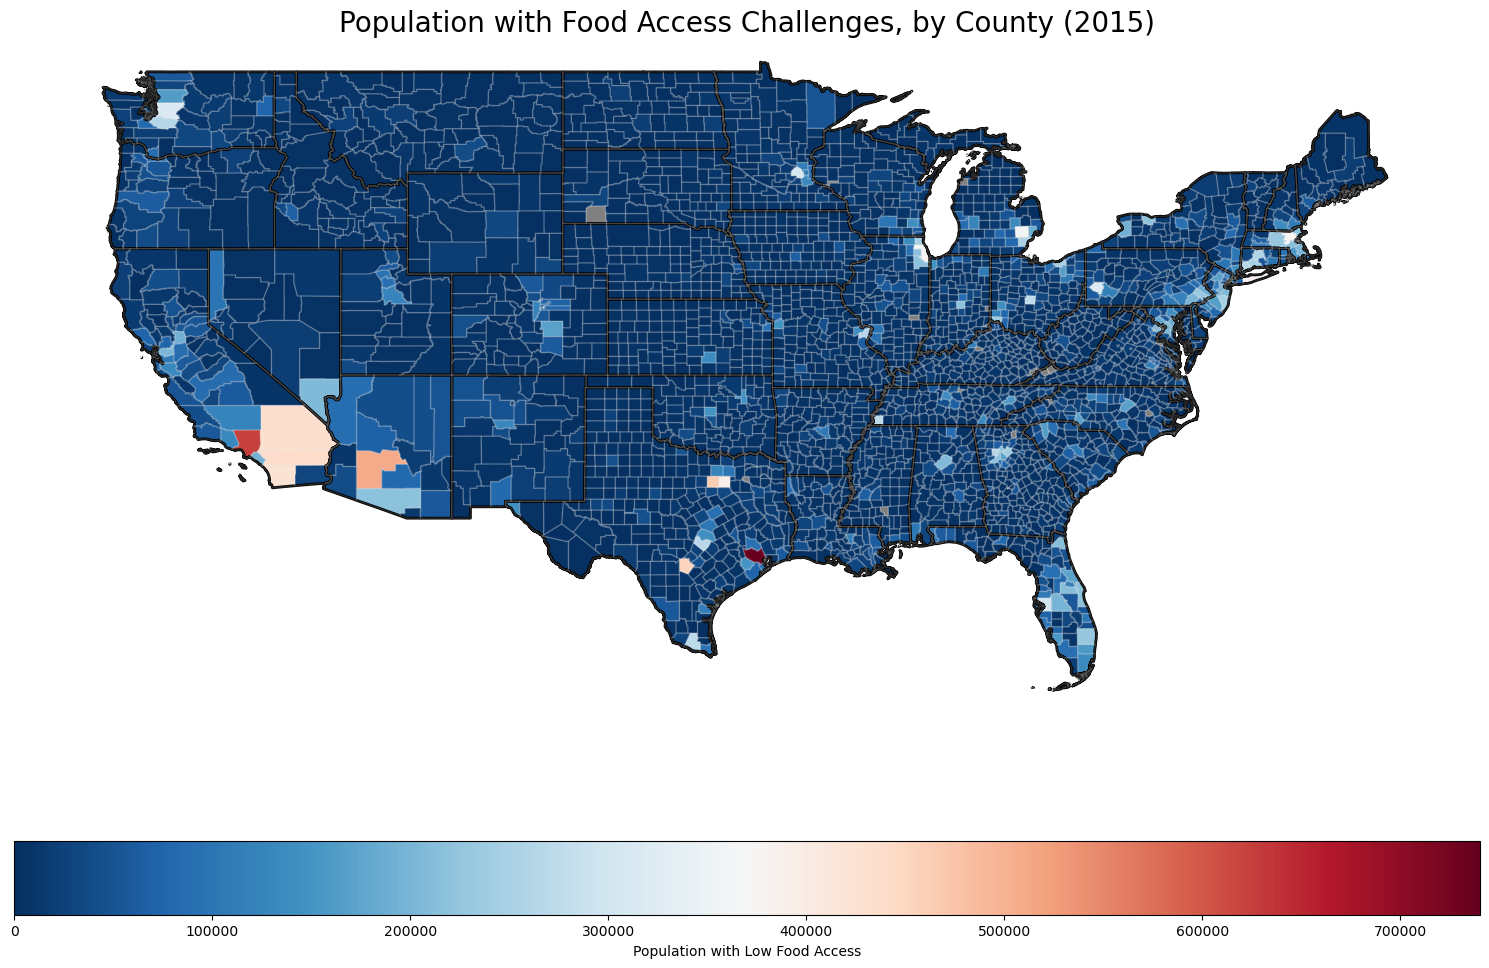

In [11]:
# plot initial map to identify hotspots on contiguous us

fig, ax = plt.subplots(1, 1, figsize = (15, 10))

counties.plot(
    color='grey',
    ax=ax
)

usda_geo.plot(
    column = 'LACCESS_POP15',  
    ax = ax,
    legend = True,
    legend_kwds = {'label' : 'Population with Low Food Access', "orientation" : "horizontal"},
    cmap = 'RdBu_r'
)

#focus on contiguous us
ax.set_xlim([-125, -66.5])
ax.set_ylim([24, 49.5])
ax.axis('off')

# add boundaries for visibility
states.boundary.plot(ax = ax, linewidth = 2, color = 'black', alpha = 1)
counties.boundary.plot(ax = ax, linewidth = 1, color = 'white', alpha = .15)

plt.title('Population with Food Access Challenges, by County (2015)', pad=20, fontsize=20)
plt.tight_layout()
plt.show()

# verify colorsafeness
# colormaps = plt.colormaps()
# print(colormaps)

In [12]:
# looks like southern california on the border of arizona is a key spot... can i verify this with numbers?

# define functions to do the following:
# get neighboring counties
# get aggregated population of low food access in both center and neighboring counties
# look at all different combinations and find the maximum

results = []

# get all of the neighboring counties for a given fips code
    # 1. find target county on  map
    # 2. get shape of target county
    # 3. find counties that touch target county
    
#Find all counties that share a border with the target county.
    #Args: gdf (GeoDataFrame): Geographic dataframe containing county boundaries
    #Args: center_fips (str): FIPS code of the target county
    #Returns: list: FIPS codes of neighboring counties
def get_neighboring_counties(gdf, center_fips):
    
    center_county = gdf[gdf['FIPS'] == center_fips]
    if len(center_county) == 0:
        return []
    
    center_geometry = center_county.geometry.iloc[0]
    neighbors = gdf[gdf.geometry.touches(center_geometry)]['FIPS'].tolist()
    return neighbors


# get total population of low food access for a given fips code and surrounding counties
    # 1. get list of counties using the previous function
    # 2. create list of counties (neighbors + our target county)
    # 3. get data for counties from our dataset
    # 4. if no data, return 0 and empty list
    # 5. add up people with low food access in counties
    # 6. return total and list of county IDs
    
# Calculate total population with low food access for a county and its neighbors.
    # Args: center_fips (str): FIPS code of the target county
    # Returns: tuple: (total_population, list_of_fips_codes)
        # total_population: Sum of people with low food access
        # list_of_fips_codes: FIPS codes for all counties included
def get_region_total(center_fips):
    
    neighbors = get_neighboring_counties(usda_geo, center_fips)
    all_counties = neighbors + [center_fips]
    region_data = usda[usda['FIPS'].isin(all_counties)]
    
    if len(region_data) == 0:
        return 0, []
    
    total = region_data['LACCESS_POP15'].sum()
    fips = region_data['FIPS'].tolist()
    return total, fips

In [13]:
# go through EVERY county
for fips in usda['FIPS'].unique():
    total, county = get_region_total(fips)
    
    results.append({
        
        'center_fips': fips,
        'center_county': usda[usda['FIPS'] == fips]['County'].iloc[0],
        'center_state': usda[usda['FIPS'] == fips]['State'].iloc[0],
        'total_laccess': total,
        'fips': county
        
    })
    
# convert dataframe, sort by total_laccess to find the best target
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('total_laccess', ascending=False)

# select the top target, did not reset index so we can use index on row
#print(results_df.loc[221,'fips'])
targets = results_df.loc[221,'fips']

# looks like San Bernardino County, CA. + surrounding counties are both visually and numerically the best target
center_county = usda_geo[usda_geo['FIPS'] == results_df.loc[221,'center_fips']]
neighbor_counties = usda_geo[usda_geo['FIPS'].isin(results_df.loc[221,'fips'])]

# remove center county from neighbor counties,
neighbor_counties = neighbor_counties.loc[~neighbor_counties['FIPS'].isin(center_county['FIPS'])]

# create lists to store fips codes for chosen counties
centerFIPS = center_county['FIPS'].tolist()
neighborFIPS = neighbor_counties['FIPS'].tolist()


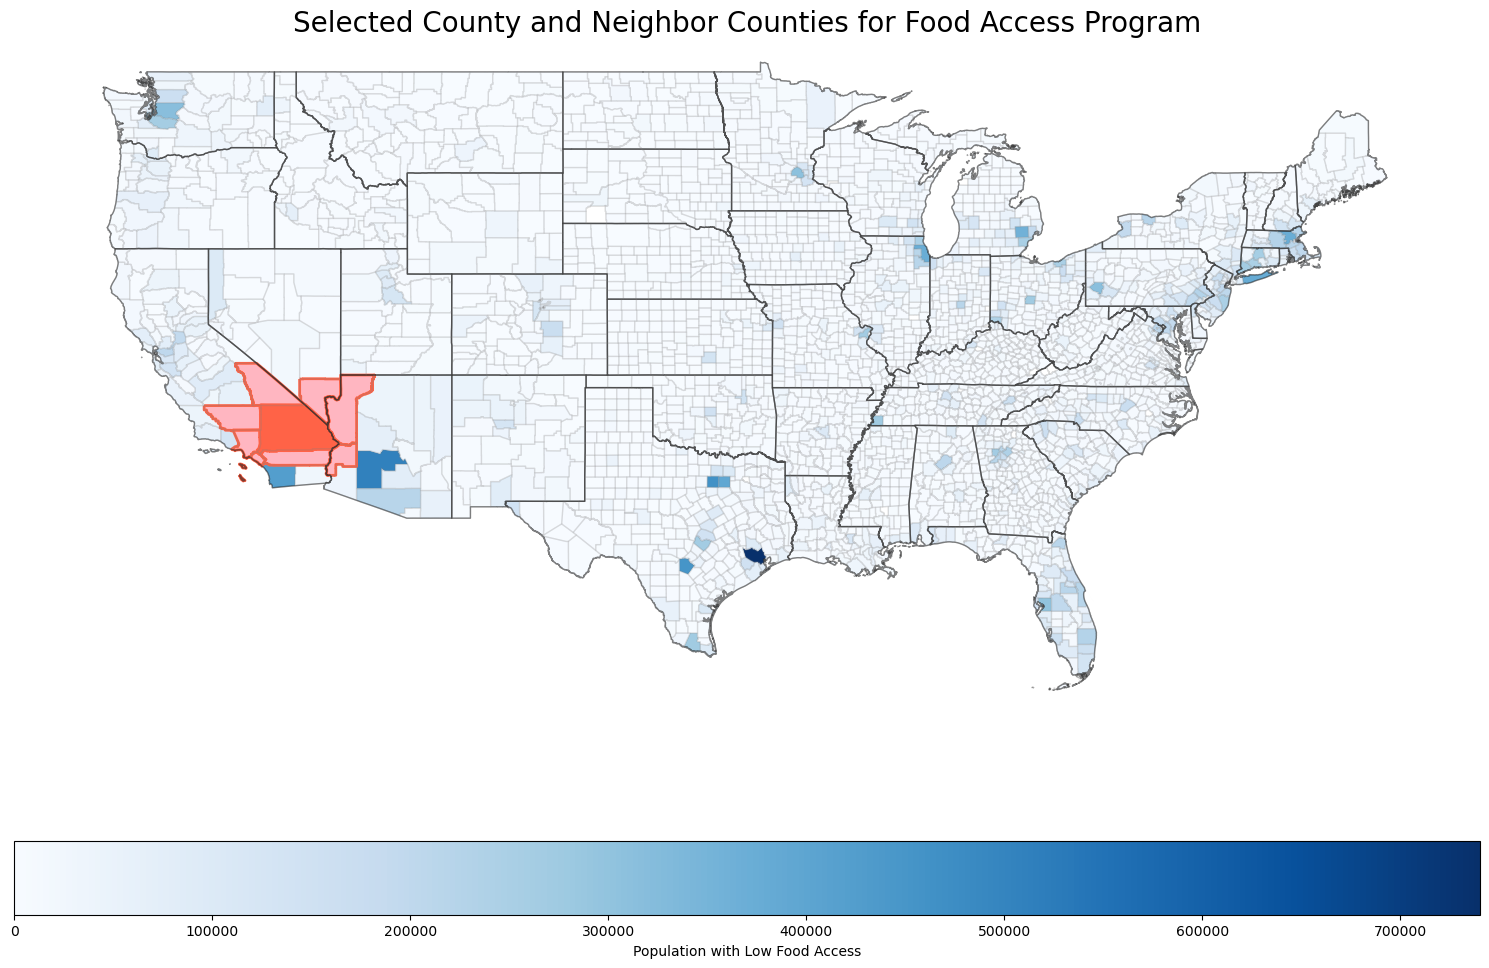

In [14]:
# plot chosen county by overall number of peopple who face food access challenges
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

usda_geo.plot(
    column = 'LACCESS_POP15',  
    ax = ax,
    cmap = 'Blues',
    legend = True,
    legend_kwds = {'label' : 'Population with Low Food Access', "orientation" : "horizontal"}
)

neighbor_counties.plot(
    color = 'lightpink',
    ax = ax
    )

center_county.plot(
    color = 'tomato',
    ax = ax
)

# set map for contiguous US
ax.set_xlim([-125, -66.5])
ax.set_ylim([24, 49.5])
ax.axis('off')

# add boundaries
neighbor_counties.boundary.plot(color = 'tomato', linewidth = 2, ax = ax)
center_county.boundary.plot(color = 'tomato', linewidth = 3, ax = ax)
states.boundary.plot(ax = ax, linewidth = 1, color = 'black', alpha = .5)
counties.boundary.plot(ax = ax, linewidth = 1, color = 'grey', alpha = .15)
plt.title('Selected County and Neighbor Counties for Food Access Program', pad = 20, fontsize = 20)
plt.tight_layout()
plt.show()

#### 2. How many people will be included? How many might be successfully engaged?
    # Implementation will be in San Bernardino County, CA.
    # Considerations: Implementing does not mean access, will not be 1-1, travel, distance, etc.
    # At most I believe we can expect to engage 80% of the county we implement the program in.
    # We can expect that if they experience food access challenges, they will also struggle to travel to the program, exacerbated by distance
    # Therefore for surrounding counties we can expect to engage 30% of the population.
        # Objectives :
    # 1. Calculate full included population
    # 2. Calculate engagement for program


In [15]:
# calculate the number of people included in the program based on center + neighboring counties
peopleInc = int(results_df.loc[221,'total_laccess'])
print(peopleInc)

# 80% of the county we implement the program in
tarCount = int(((usda.loc[usda['FIPS'].isin(centerFIPS)]['LACCESS_POP15'].iloc[0] * .8)).round())

# 30% for surrounding counties
surCount = int((usda[usda['FIPS'].isin(neighborFIPS)]['LACCESS_POP15'].sum() * .3).round())

print(f'From the total included population of {peopleInc}, we can expect to target {tarCount} people in the selected county, and {surCount} people in the surrounding counties.')
print(f'This is a total of {tarCount + surCount} or {((tarCount + surCount) / peopleInc) * 100}% people engaged in the program.')

2122694
From the total included population of 2122694, we can expect to target 346523 people in the selected county, and 506862 people in the surrounding counties.
This is a total of 853385 or 40.20292138197969% people engaged in the program.


    #### 3. Which subgroup of the population might benefit the most from the program?

    # Objectives :
    # 1. Calculate the number of people in each subgroup including subgroups beyond racial and ethnic groups with county multipliers.
    # 2. Calculate the total demographic breakdown of low food access by ethnic traits with no overlaps.

    #### Answer: The Subgroups that will benefit the most are Whites, Hispanis, Low Income, Children, Multiracial groups, and Seniors, when accounting for just ethnic characteristics, whites and hispanics benefit the most.

In [16]:
# explore variable list
# display(var_list['Variable_Code'].unique())
# display(var_list[(var_list['Subcategory_Name'] == 'Race & Age')])
# display(var_list[(var_list['Subcategory_Name'] == 'Race & Age')]['Variable_Code'])

# get low access columns from usda and target counties to do subgroup analysis
laccess_cols = ['FIPS'] + [col for col in usda.columns if 'LACCESS' in col]
target_counties = usda[usda['FIPS'].isin(targets)][laccess_cols]
target_counties = target_counties.loc[:, (~target_counties.columns.str.startswith('PCH'))]
target_counties = target_counties.loc[:, (~target_counties.columns.str.startswith('PCT'))]

# display(target_counties)
# target_counties.columns

# for col in target_counties.columns:
    # print(f"\n{str(col)}:")
    # matching_var = var_list[var_list['Variable_Code'] == col]
    # if not matching_var.empty:
        # print(matching_var['Variable_Name'].iloc[0])
    # else:
        # print("No matching variable found")

# display(target_counties)

In [17]:
# use the previous .8 and .3 multipliers for counties data to accurately calculate population for each county and subgroup
surCountSum = target_counties[target_counties['FIPS'] != centerFIPS[0]].sum(numeric_only=True)
tarCoutSum = target_counties[target_counties['FIPS'] == centerFIPS[0]].sum(numeric_only=True)
allCountSum = .3 *surCountSum + .8 * tarCoutSum

# create dataframe to display results
target_sums_df = pd.DataFrame(allCountSum).reset_index()
target_sums_df.columns = ['Variable', 'Sum']

# sort and display results to understand subgroup population
display(target_sums_df.sort_values(by = 'Sum', ascending = False))

# subgroups that will beneift the most are Whites, Hispanis, Low Income, Children, and Seniors.

,Variable,Sum
0,LACCESS_POP15,853384.909893
7,LACCESS_WHITE15,548998.785669
9,LACCESS_HISP15,301997.471145
1,LACCESS_LOWI15,281784.828139
4,LACCESS_CHILD15,222800.352604
13,LACCESS_MULTIR15,168157.740371
6,LACCESS_SENIORS15,102148.229735
8,LACCESS_BLACK15,62583.022957
10,LACCESS_NHASIAN15,62377.049766
3,LACCESS_SNAP15,26126.839921


In [18]:
# calculate population breakdown for each county and ethnic group within
surCountSumFull = target_counties[target_counties['FIPS'] != centerFIPS[0]].sum(numeric_only=True)
tarCoutSumFull = target_counties[target_counties['FIPS'] == centerFIPS[0]].sum(numeric_only=True)
allCountSumFull = surCountSumFull + tarCoutSumFull

# create dataframe to display results
target_sums_dfFull = pd.DataFrame(allCountSumFull).reset_index()
target_sums_dfFull.columns = ['Variable', 'Sum']
target_sums_dfFull.drop(index = [5, 0, 1, 4, 13, 6, 3, 2], inplace = True)
# sort and display results to understand subgroup population
display(target_sums_dfFull.sort_values(by = 'Sum', ascending = False))

,Variable,Sum
7,LACCESS_WHITE15,1.376022e+06
9,LACCESS_HISP15,7.217346e+05
10,LACCESS_NHASIAN15,1.691731e+05
8,LACCESS_BLACK15,1.487404e+05
11,LACCESS_NHNA15,2.051762e+04
12,LACCESS_NHPI15,6.042681e+03


In [19]:
target_sums_dfFull.loc[10, 'Sum']


169173.14345818976

    #### 4.What is the projected impact of this program?

    # Objectives :
    # 1. Plot the population with low food access vs the total population
    # 2. Plot the number demographic breakdown of low food access groups in targeted population
    # 3. Plot the breakdown of engagement against all targets
    # 4. Plot the % of engagement each county will make up
    # 5. Present the results as a projected impact and break down the whole report so far.

    #### Answer: We can expect to target 80% of the population in the selected county and 30% of the population in the surrounding counties. This is a total of 853385 people out of a total of population of 2122694 individuals who have low food access in the selected county and surrounding counties.
    
    # Of this group, the subgroups that will benefit the most are Whites, Hispanics, Low Income, Children, and Senior Citizens.
    # Broken out into ethnic groups, the subgraoups that will beneift the most are whites, hispanics, and Asians in that order.
    # We can reduce the number of people with low food access by around 40% by establishing a program in this region.

    # California is the largest agricultural producer in the US, this makes fresh food easily accessible for a food access program.
    # The program can operate close to the Central Valley farmland, reducing costs and allows for direct sourcing from farms to benefit the local market.
    # California is a friendly state to social service programs and farmers have incentives to work with food banks, making finding partnerships and establish connections easy.

    #### END NOTES
    # I feel the CDC data may be useful to predict outcomes for food access issues, theoretically you could compare how lower food access rates impact measured health outcomes, but the results of such findings would likely just reinforce targeting areas with high food access issues, which will circle back to the same analysis as this report.

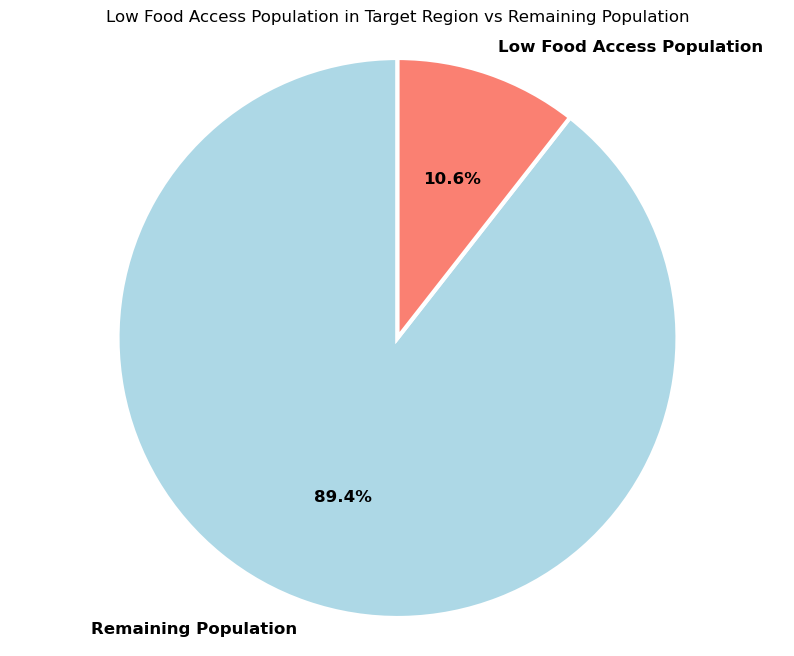

In [20]:
# 1. Plot the population with low food access vs the total population

# calculate values for target and surrounding counties
allpop = int(usda.loc[usda['FIPS'].isin(centerFIPS + neighborFIPS), 'pop_est'].sum())
labels = ['Remaining Population', 'Low Food Access Population']
sizes = [(allpop - peopleInc), peopleInc]

plt.figure(figsize=(10, 8))
plt.pie(sizes, 
        labels = labels, 
        autopct = '%1.1f%%', 
        startangle = 90, 
        colors = ['lightblue', 'salmon'],
        wedgeprops = {
            'edgecolor': 'white',
            'linewidth': 3,
            'antialiased': True
        },
        textprops = {
            'fontsize': 12,
            'fontweight': 'bold'
        }
        )

plt.title('Low Food Access Population in Target Region vs Remaining Population')
plt.axis('equal')
plt.show()

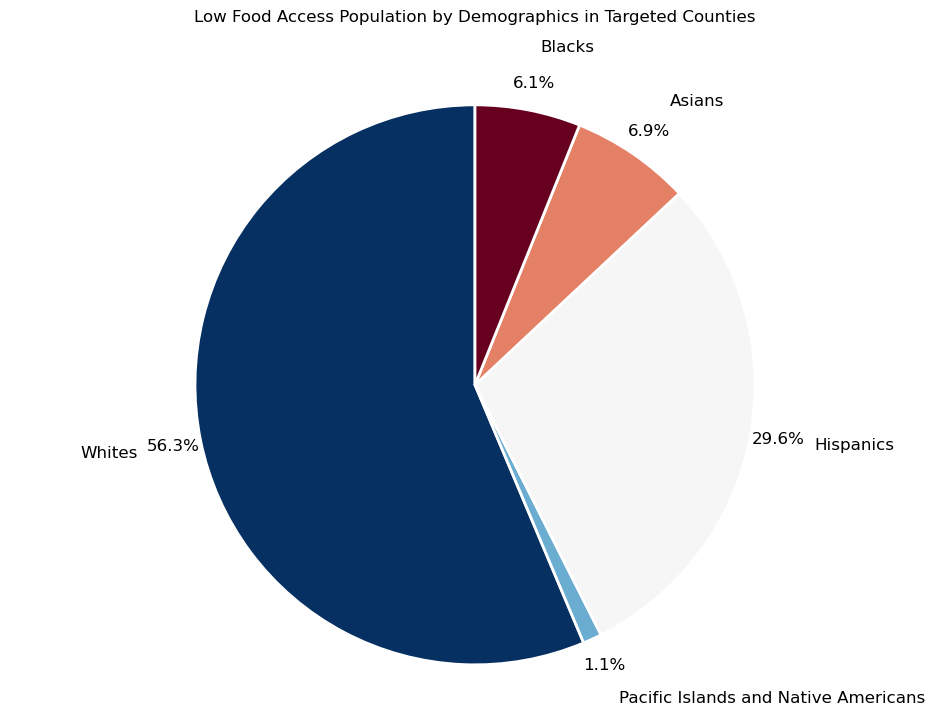

In [21]:
# 2. Plot the number demographic breakdown of low food access groups in targeted population

# calculate values for targeted counties and breakdown by subgroups
labels = ['Whites', 'Pacific Islands and Native Americans', 'Hispanics', 'Asians', 'Blacks']
sizes = [
    target_sums_dfFull.loc[target_sums_dfFull['Variable'] == 'LACCESS_WHITE15', 'Sum'].iloc[0],
    target_sums_dfFull.loc[target_sums_dfFull['Variable'] == 'LACCESS_NHNA15', 'Sum'].iloc[0] + target_sums_dfFull.loc[target_sums_dfFull['Variable'] == 'LACCESS_NHPI15', 'Sum'].iloc[0],
    target_sums_dfFull.loc[target_sums_dfFull['Variable'] == 'LACCESS_HISP15', 'Sum'].iloc[0],
    target_sums_dfFull.loc[target_sums_dfFull['Variable'] == 'LACCESS_NHASIAN15', 'Sum'].iloc[0],
    target_sums_dfFull.loc[target_sums_dfFull['Variable'] == 'LACCESS_BLACK15', 'Sum'].iloc[0]
]

n_colors = len(sizes)
colors = plt.cm.RdBu_r(np.linspace(0, 1, n_colors))

plt.figure(figsize = (12, 8))
plt.pie(sizes, 
        labels = labels, 
        autopct = '%1.1f%%', 
        startangle = 90, 
        colors = colors,
        wedgeprops = {'edgecolor': 'white', 'linewidth': 2},
        textprops = {'fontsize': 12},
        pctdistance = 1.1,
        labeldistance = 1.23
)

plt.title('Low Food Access Population by Demographics in Targeted Counties', pad = 40)
plt.axis('equal')
plt.show()

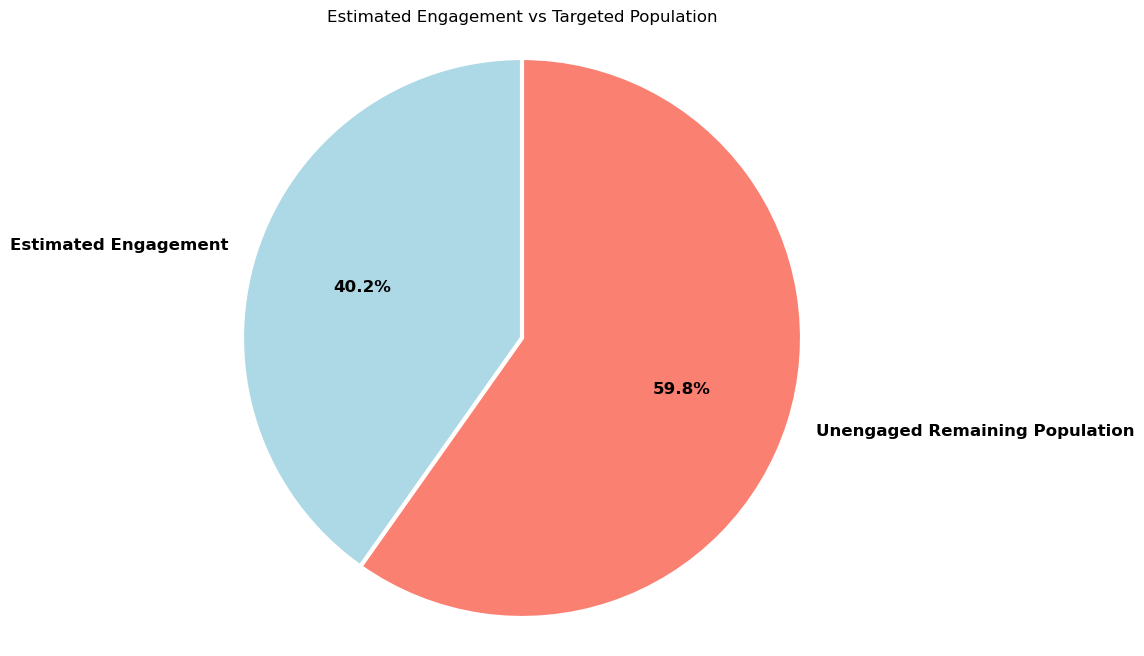

In [22]:
# 3. Plot the breakdown of engagement against all targets
    
labels = ['Estimated Engagement', 'Unengaged Remaining Population']
sizes = [(tarCount + surCount), peopleInc - (tarCount + surCount)]

plt.figure(figsize=(10, 8))
plt.pie(sizes, 
        labels = labels, 
        autopct = '%1.1f%%', 
        startangle = 90, 
        colors = ['lightblue', 'salmon'],
        wedgeprops = {
            'edgecolor': 'white',
            'linewidth': 3,
            'antialiased': True
        },
        textprops = {
            'fontsize': 12,
            'fontweight': 'bold'
        }
        )

plt.title('Estimated Engagement vs Targeted Population')
plt.axis('equal')
plt.show()

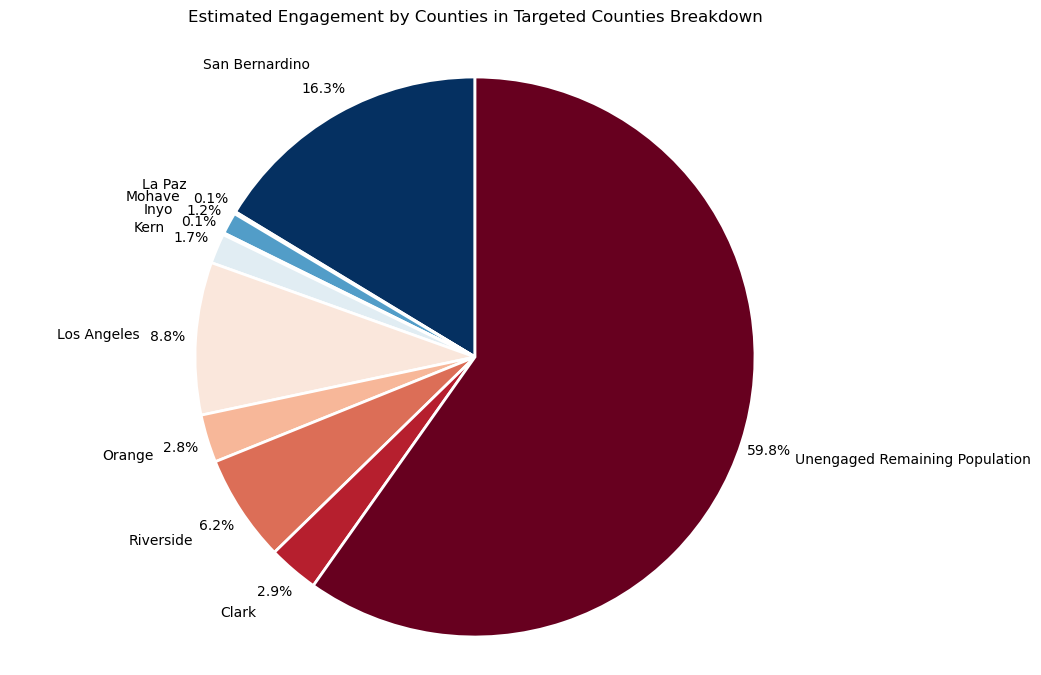

In [23]:
# 4. Plot the % of engagement each county will make up

# calculate values for targeted counties and breakdown by subgroups
subset_counties = pd.concat([center_county, neighbor_counties])
labels = subset_counties['County'].tolist()
labels.append('Unengaged Remaining Population')

sizes = [
    subset_counties.loc[subset_counties['County'] == 'San Bernardino', 'LACCESS_POP15'].iloc[0] * .8,
    subset_counties.loc[subset_counties['County'] == 'La Paz', 'LACCESS_POP15'].iloc[0] * .3,
    subset_counties.loc[subset_counties['County'] == 'Mohave', 'LACCESS_POP15'].iloc[0] * .3,
    subset_counties.loc[subset_counties['County'] == 'Inyo', 'LACCESS_POP15'].iloc[0] * .3,
    subset_counties.loc[subset_counties['County'] == 'Kern', 'LACCESS_POP15'].iloc[0] * .3,
    subset_counties.loc[subset_counties['County'] == 'Los Angeles', 'LACCESS_POP15'].iloc[0] * .3,
    subset_counties.loc[subset_counties['County'] == 'Orange', 'LACCESS_POP15'].iloc[0] * .3,
    subset_counties.loc[subset_counties['County'] == 'Riverside', 'LACCESS_POP15'].iloc[0] * .3,
    subset_counties.loc[subset_counties['County'] == 'Clark', 'LACCESS_POP15'].iloc[0] * .3,
    peopleInc - (tarCount + surCount)
]

n_colors = len(sizes)
colors = plt.cm.RdBu_r(np.linspace(0, 1, n_colors))

plt.figure(figsize = (12, 8))
plt.pie(sizes, 
        labels = labels, 
        autopct = '%1.1f%%', 
        startangle = 90, 
        colors = colors,
        wedgeprops = {'edgecolor': 'white', 'linewidth': 2},
        textprops = {'fontsize': 10},   
        pctdistance = 1.1,
        labeldistance = 1.2
)

plt.title('Estimated Engagement by Counties in Targeted Counties Breakdown', pad = 20)
plt.axis('equal')
plt.show()